In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import plotly
import plotly.express as px
import plotly.graph_objects as go

from pathlib import Path

from matplotlib import pyplot as plt
from prettytable import PrettyTable

from scipy.stats import spearmanr
from scipy import signal as sig

from numpy import fft

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm.notebook import tqdm_notebook

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet import Prophet

plotly.offline.init_notebook_mode(connected=True)

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
def abs_error(
    y_true: np.array, 
    y_pred: np.array, 
    mask_true_vals: np.array = None
) -> np.array:
    """
    Computes MAE 
    If mask_true_vals is passed 
    then use it to skip errors for False values

    Parameters
    ----------
    y_true : np.array
    y_pred : np.array
    mask_true_vals : np.array, optional
        array of bool values, by default None

    Returns
    -------
    np.array
        [description]
    """
    e = np.abs(y_true - y_pred)
    if not (mask_true_vals is None):
        e = np.where(mask_true_vals, e, 0)
    return e


def smape(
    y_true: np.array, 
    y_pred: np.array, 
    mask_true_vals: np.array = None
) -> np.array:
    """
    Computes SMAPE
    If mask_true_vals is passed 
    then use it to skip errors for False values

    Parameters
    ----------
    y_true : np.array
    y_pred : np.array
    mask_true_vals : np.array, optional
        array of bool values, by default None

    Returns
    -------
    np.array
        [description]
    """
    denominator = (np.abs(y_true) + np.abs(y_pred))
    e = abs_error(y_true, y_pred, mask_true_vals)
    diff = e / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)


def scaled_naive_error(
    y_true: np.array, 
    y_pred: np.array, 
    mask_true_vals: np.array = None
) -> np.array:
    """
    Computes MAE and normalize it on error 
    with simple MAE prediction

    If mask_true_vals is passed 
    then use it to skip errors for False values

    Parameters
    ----------
    y_true : np.array
    y_pred : np.array
    mask_true_vals : np.array, optional
        array of bool values, by default None

    Returns
    -------
    np.array
        [description]
    """
    e = abs_error(y_true, y_pred, mask_true_vals)[1:]
    eps = 0.1 ** 3
    denominator = np.diff(y_true)
    e_scaled = (e + eps) / (denominator + eps)
    return np.mean(e_scaled)


def weekly_weighted_error(
    y_true: np.array, 
    y_pred: np.array, 
    mask_true_vals: np.array = None
) -> np.array:
    """
    Computes MAE and gives linear decreasing weights
    for each week
    so error in nearest future is more expensive
    than error in far future

    If mask_true_vals is passed 
    then use it to skip errors for False values

    Parameters
    ----------
    y_true : np.array
    y_pred : np.array
    mask_true_vals : np.array, optional
        array of bool values, by default None

    Returns
    -------
    np.array
        [description]
    """
    n = len(y_true) // 7 + 1
    w = np.repeat(np.arange(1, n + 1), 7)[:len(y_true)]
    w_normed = w / np.sum(w)
    e = abs_error(y_true, y_pred, mask_true_vals)
    return np.sum(e * w_normed)


def corr_error(y_true: np.array, y_pred: np.array)-> np.array:
    """[summary]
    Computes simple Pirson correlation
    to check if dynamics in the series 
    is similar 

    Parameters
    ----------
    y_true : np.array
        [description]
    y_pred : np.array
        [description]

    Returns
    -------
    np.array
        [description]
    """
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    return corr


def print_report(
    y_true: np.array, 
    y_pred: np.array, 
    mask_true_vals: np.array = None
) -> np.array:
    """
    prints report with metrics

    Parameters
    ----------
    y_true : np.array
        [description]
    y_pred : np.array
        [description]
    mask_true_vals : np.array, optional
        [description], by default None

    Returns
    -------
    np.array
        [description]
    """
    report = PrettyTable()
    report.field_names = ["Metric", "Value"]

    report.add_row(["SMAPE % (less is better)", smape(y_true, y_pred, mask_true_vals)])
    report.add_row(["Scaled MAE on naive (less is better)", scaled_naive_error(y_true, y_pred, mask_true_vals)])
    report.add_row(["MAE weekly weighted (less is better)", weekly_weighted_error(y_true, y_pred, mask_true_vals)])
    report.add_row(["Correlation similarity (more is better)", corr_error(y_true, y_pred)])

    print(report)


def make_plots(
    method_name: str, 
    x: pd.DatetimeIndex, 
    y: np.array,
    x_test: pd.DatetimeIndex, 
    y_test: np.array, 
    yhat: np.array, 
    yhat_test: np.array, 
):
    """
    Generates plot with train and test parts

    Parameters
    ----------
    method_name : str
        [description]
    x : pd.DatetimeIndex
        [description]
    y : np.array
        [description]
    x_test : pd.DatetimeIndex
        [description]
    y_test : np.array
        [description]
    yhat : np.array
        [description]
    yhat_test : np.array
        [description]
    """
    y_style = dict(color="#81caff", width=4)
    yhat_style = dict(color="#f99d82", width=2) 
    y_test_style = dict(color="#2da7ff", width=4)  
    yhat_test_style = dict(color="#ef6c64", width=2)

    x = pd.to_datetime(x)
    x_test = pd.to_datetime(x_test)

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x, y=y,mode='lines', 
        name="y train", line=y_style))
    fig.add_trace(go.Scatter(
        x=x_test, y=y_test,mode='lines', 
        name="y test", line=y_test_style))

    fig.add_trace(go.Scatter(
        x=x, y=yhat,mode='lines', 
        name="y train forecast", line=yhat_style))
    fig.add_trace(go.Scatter(
        x=x_test, y=yhat_test, mode='lines', 
        name="y test forecast", line=yhat_test_style))
    fig.update_layout(
        title = method_name,
        xaxis_tickformat = '%d %B <br>%Y',
        template="plotly_white"
    )
  
    fig.show()


def get_test_mask(y: pd.Series, test_period = "1y"):
    mask_test = y.index >= (y.index.max() - pd.Timedelta(test_period))
    
    return mask_test

    
def split_series(y: pd.Series, mask_true_vals: np.array, test_period = "1y"):
    mask_test = get_test_mask(y, test_period)
    mask_train = ~mask_test

    y_train = y.loc[mask_train]
    y_test = y.loc[mask_test]

    x_train = y_train.index
    x_test = y_test.index
    
    mask_true_train = mask_true_vals[mask_train]
    mask_true_test = mask_true_vals[mask_test]

    return (y_train, x_train, mask_true_train, y_test, x_test, mask_true_test)


def fourier_extrapolation(
    y: np.array, 
    n_predict: int, 
    n_harm: int
) -> np.array:
    """
    find Extrapolation using first n harmonies
    from Fourie components

    based on https://gist.github.com/tartakynov/83f3cd8f44208a1856ce

    Parameters
    ----------
    y : np.array
        [description]
    n_predict : int
        [description]
    n_harm : int
        [description]

    Returns
    -------
    np.array
        [description]
    """
    n = y.size
    y_fft = fft.fft(y) 
    freq = fft.fftfreq(n)
    indexes = list(range(n))
    indexes.sort(key = lambda i: np.absolute(freq[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    
    for i in indexes[ : (1 + n_harm * 2)]:
        amp = np.absolute(y_fft[i]) / n   # amplitude
        phase = np.angle(y_fft[i])          # phase
        restored_sig += amp * np.cos(2 * np.pi * freq[i] * t + phase)
    
    return restored_sig


In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Dataset

**Nifty-50 Stock Market Data**

The [dataset](https://www.kaggle.com/rohanrao/nifty50-stock-market-data) used is stock market data of the Nifty-50 index from NSE (National Stock Exchange) India over the last 20 years (2000 - 2019)

The historic **VWAP (Volume Weighted Average Price)** is the target variable to predict. VWAP is a trading benchmark used by traders that gives the average price the stock has traded at throughout the day, based on both volume and price.   
Read more about the dataset: https://www.kaggle.com/rohanrao/nifty50-stock-market-data

The stock used is **BAJAJFINSV**.

In [6]:
# dir_data = Path("/content/gdrive/My Drive/Data Science Basic/10 Time Series/WorkShop/Data")
# dir_data = Path("../Data")

In [7]:
df = pd.read_csv("BAJAJFINSV.csv", index_col=["Date"], parse_dates=["Date"])
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,NaN,908264,0.2888
2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,NaN,677627,0.1558
2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,NaN,774895,0.1689
2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,NaN,1006161,0.2225
2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,NaN,462832,0.1514


In [8]:
df.shape

(2992, 14)

# EDA

## Check date duplicates

In [9]:
indx_dupl = df.index.duplicated()

In [10]:
np.sum(indx_dupl)

0

## Check missing values

In [11]:
df.isna().sum()

Symbol                  0
Series                  0
Prev Close              0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
VWAP                    0
Volume                  0
Turnover                0
Trades                745
Deliverable Volume      0
%Deliverble             0
dtype: int64

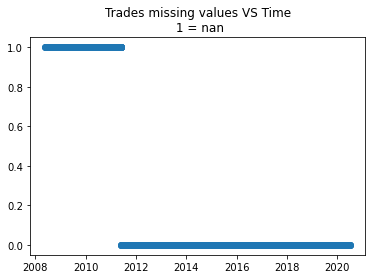

In [12]:
plt.plot(df.Trades.isna()*1, 'o')
plt.title('Trades missing values VS Time\n 1 = nan');

In such case we may remove 1.5 year of data, as we still have enough data

In [13]:
df = df.loc[~df.isna().any(axis=1)]

## Quick Look on the data

In [14]:
numeric_columns = ['Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble']

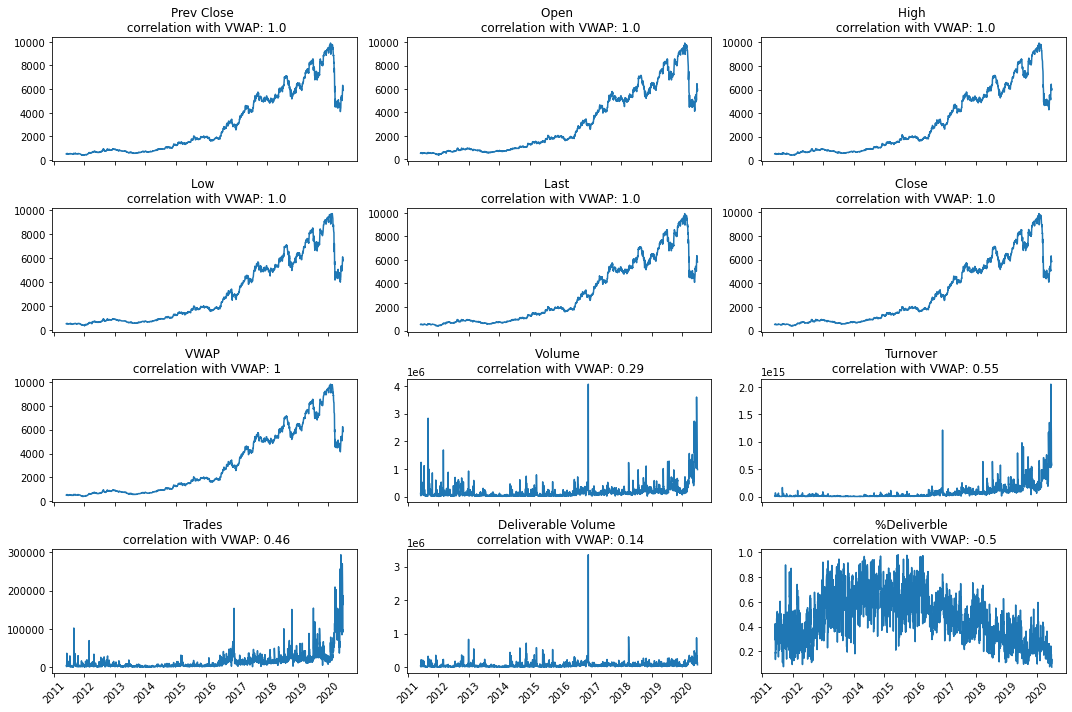

In [15]:
ncols = 3 
nrows = int(len(numeric_columns) / 3)
fig, axs = plt.subplots(
  nrows, ncols, sharex=True, sharey=False,
  figsize=(15, 10)
)

for i, col in enumerate(numeric_columns):
    axs[i // ncols, i % ncols].plot(df[col])
    if col != "VWAP":
        cor = df[[col, 'VWAP']].corr().round(2).loc[col, "VWAP"]
    else:
        cor = 1
    axs[i // ncols, i % ncols].set_title(
      f"{col} \n correlation with VWAP: {cor}"
    )
    plt.setp(
      axs[i // ncols, i % ncols].xaxis.get_majorticklabels(), 
      rotation=45
    )

plt.tight_layout()
plt.show()

As we don't have a lot of time, we are going to forecast one dimentional series (target itself),
but as the next step I would defenetly recommend try forecst VWAP using history of other time series

# Prepare data

We need to check the frequency of data if the intervals between points are equal

In [16]:
df.index

DatetimeIndex(['2011-06-01', '2011-06-02', '2011-06-03', '2011-06-06',
               '2011-06-07', '2011-06-08', '2011-06-09', '2011-06-10',
               '2011-06-13', '2011-06-14',
               ...
               '2020-06-17', '2020-06-18', '2020-06-19', '2020-06-22',
               '2020-06-23', '2020-06-24', '2020-06-25', '2020-06-26',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=2247, freq=None)

In [17]:
df = df.sort_index()

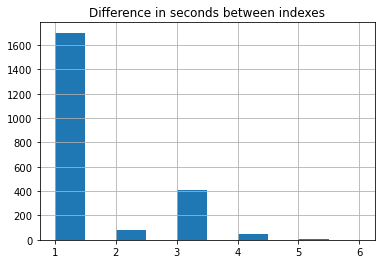

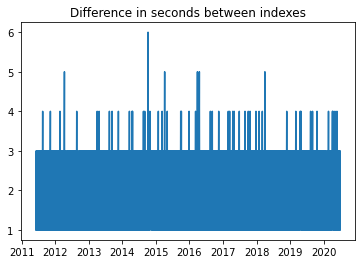

In [18]:
df_index_diff = df.index.to_series().diff()
df_index_diff = df_index_diff.dt.total_seconds() // 60 // 60 // 24

df_index_diff.hist()
plt.title("Difference in seconds between indexes")
plt.show()

plt.plot(df_index_diff)
plt.title("Difference in seconds between indexes")
plt.show()

We have 2 options:

1) Resample data on weekly / monthly basis

2) Fill missing data

We are going to use the second one (as more complex case)|

In [19]:
df_new = df.resample('1d').mean()

In [20]:
df_new = df_new.fillna(method="pad")

ALl mess happened in 2020 changed the time series regime, so we are going to cut it off, to simplify the task in educational purposes

In [21]:
df_new = df_new.loc[df_new.index.year < 2020]
mask_true_vals = df_new.index.isin(df.index)

In [22]:
df_new.shape

(3136, 12)

When we will calculate our metrics, we will exclude filled values in order not to have bias during evaluation.

# Metrics

All metrics defined for regression problem are appropriate, but we can invent modifications for time-series case.

Let's define error for time series case:
$$
e_{t+h} = y_{t+h} - \hat{y}_{t+h|t}
$$

Some authors propose to use errors scaled by naive-forecast error:

$$
e^*_{j} = \frac{|e_{j}|}{|y_{j} - y_{j-1}|}
$$

$$
e^* = \frac{1}{T} \sum_{j=1}^T e^*_{j}
$$

Or we can give higher weights for errors in the nearest future.

$$
\tilde{e} = \frac{2}{T(T-1)} \sum_{j=1}^T (T - j) e_{j}
$$


Further we are ging to calculate two metrics described above and SMAPE. As we do not have strictly specified goal of forecasting we choose metrics in educational purposes.

For checking if the dynamics of two series is similar we are going to use correlation coefficient.

# Forecasting - naive approach

In [23]:
(y_train, x_train, mask_true_train, y_test, x_test, mask_true_test) = split_series(df_new["VWAP"], mask_true_vals)

In [24]:
n_train = len(x_train)
n_test = len(x_test)

## Simple Exponential Smoothing

Let's check how the smoothing on raw data is performed

In [25]:
model = SimpleExpSmoothing(y_train.values)
model_fit = model.fit()
yhat = model_fit.predict(start=0, end=n_train-1)
yhat_test =  model_fit.predict(start=n_train, end=n_train+n_test-1)

In [26]:
make_plots("Simple Exponential Smoothing", x_train, y_train, x_test, y_test, yhat, yhat_test)

In [27]:
print_report(y_test, yhat_test, mask_true_test)

+-----------------------------------------+-------------------------+
|                  Metric                 |          Value          |
+-----------------------------------------+-------------------------+
|         SMAPE % (less is better)        |    11.17969776873523    |
|   Scaled MAE on naive (less is better)  |    119.54142395611332   |
|   MAE weekly weighted (less is better)  |    1079.9311771148787   |
| Correlation similarity (more is better) | -3.8171267245549597e-16 |
+-----------------------------------------+-------------------------+


## ARIMA models

### Information Criteria

Akaike’s Information Criterion (AIC) is useful for determining the order of an ARIMA model.

$$
\text{AIC} = -2 \log(L) + 2(p+q+k+1),
$$

where $L$ is the likelihood of the data,  $k=1$ if $c \neq 0$ and $k=0$ if $c=0$. So the last term in parentheses is the number of parameters in the model.

For ARIMA models, it could be written as
$$
\text{AICc} = \text{AIC} + \frac{2(p+q+k+1)(p+q+k+2)}{T-p-q-k-2}.
$$

Good models are obtained by minimising the AIC.
It is important to note that these information criteria tend not to be good guides to selecting the appropriate order of differencing of a model, but only for selecting the values of $p$ and $q$. This is because the differencing changes the data on which the likelihood is computed, making the AIC values between models with different orders of differencing not comparable.

### Log-returns

For financial and economical time series very often log-returns are used instead of raw data. Usualy such transformation helps to achieve stationarity.

$$
r(t) = \ln \frac{Y[t]}{Y[t-1]}
$$

In [28]:
df_log_returns = df_new.loc[:, ["VWAP"]]
df_log_returns.loc[:, "log"] = np.log(df_log_returns["VWAP"])
df_log_returns.loc[:, "log-returns"] = df_log_returns["log"].diff()

In [29]:
df_log_returns.head()

,VWAP,log,log-returns
Date,,,
2011-06-01,522.81,6.259218,NaN
2011-06-02,513.71,6.241659,-0.017559
2011-06-03,513.11,6.240490,-0.001169
2011-06-04,513.11,6.240490,0.000000
2011-06-05,513.11,6.240490,0.000000


In [30]:
(
    y_logrn_train, 
    x_train, 
    mask_true_train, 
    y_logrn_test, 
    x_test, 
    mask_true_test
) = split_series(df_log_returns["log-returns"], mask_true_vals)

In [31]:
y_logrn_train = y_logrn_train.iloc[1:]
x_train = x_train[1:]

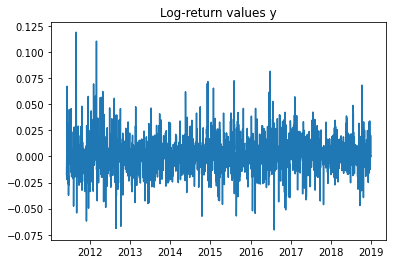

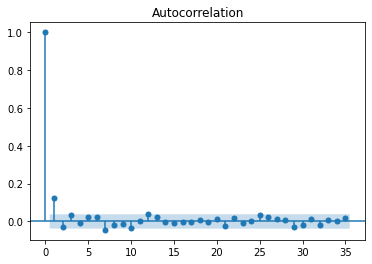

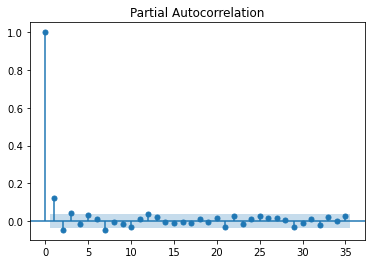

In [32]:
plt.plot(x_train, y_logrn_train)
plt.title("Log-return values y")
plt.show();
plot_acf(y_logrn_train);
plot_pacf(y_logrn_train);

As we see from plots the time series became more stationary. And according to ACF anc PACF plots we may apply ARIMA model with p,d,q equal 1,0,1 accordingly.

In [33]:
results = dict()

for p in range(2):
    for d in [0, 1]:
        for q in tqdm_notebook(range(2)):
            model = ARIMA(y_logrn_train, order=(p, d, q), freq='D')
            try:
                model_fit = model.fit(disp=0)
            except Exception as e:
                print(e)
            else:
                results[(p, d, q)] = (model_fit.aic, model_fit.llf)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
results = pd.DataFrame.from_records(results).T.rename(columns={0: "AIC", 1: "Log-likelihood"})
results = results.reset_index()

In [35]:
fig = go.Figure(data=go.Scatter(x=results["AIC"],
                                y=results["Log-likelihood"],
                                mode='markers',
                                marker_color=results["index"].apply(lambda x: x[1]),
                                text=results["index"].astype("str")))
fig.update_layout(
    title='ARIMA fitting for log-returns',
    xaxis_title="AIC",
    yaxis_title="Log-likelihood",
)
fig.show()

In [36]:
model = ARIMA(y_logrn_train, order=(1, 0, 1), freq='D')
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            log-returns   No. Observations:                 2769
Model:                     ARMA(1, 1)   Log Likelihood                7697.940
Method:                       css-mle   S.D. of innovations              0.015
Date:                Tue, 18 May 2021   AIC                         -15387.880
Time:                        14:50:32   BIC                         -15364.175
Sample:                    06-02-2011   HQIC                        -15379.319
                         - 12-30-2018                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0009      0.000      2.913      0.004       0.000       0.002
ar.L1.log-returns    -0.3738      0.108     -3.462      0.001      -0.585      -0.162
ma.L1.log-returns     0.5023      0.101      4.994      0.000       0.305       0.699
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.6751           +0.0000j            2.6751            0.5000
MA.1           -1.9908           +0.0000j            1.9908            0.5000
-----------------------------------------------------------------------------
"""

In [37]:
yhat = model_fit.predict(start=0, end=y_logrn_train.shape[0]-1)
yhat_test = model_fit.forecast(steps=y_logrn_test.shape[0])[0]

Notice, if you use model with differencing, then you need to integrate process 

<pre><code>
yhat = model_fit.predict(start=1, end=y_logrn_train.shape[0]-1)
yhat = yhat + y_logrn_train.values[:-1]  # integrate (inverse differencing)
yhat_test = model_fit.forecast(steps=y_logrn_test.shape[0])[0]
</code></pre>

In [38]:
make_plots(
    "Log-returns prediction with ARIMA(1,0,1)", 
    x_train, y_logrn_train, x_test, 
    y_logrn_test, yhat, yhat_test
)

In [39]:
df_log_returns.loc[:, "log-returns hat"] = [np.nan] + yhat.values.tolist() + yhat_test.tolist()

For train period we just do inverse transformations:

In [40]:
df_log_returns.loc[:, "VWAP hat log"] = [np.nan] + (
    df_log_returns.loc[:, "log"].iloc[:-1].values 
    + df_log_returns.loc[:, "log-returns hat"].values[1:] 
).tolist()

In [41]:
df_log_returns.loc[df_log_returns.index >= pd.DatetimeIndex(["2019-06-29"])[0]]

,VWAP,log,log-returns,log-returns hat,VWAP hat log
Date,,,,,
2019-06-29,8488.76,9.046498,0.000000,0.000909,9.047407
2019-06-30,8488.76,9.046498,0.000000,0.000909,9.047407
2019-07-01,8543.52,9.052928,0.006430,0.000909,9.047407
2019-07-02,8464.08,9.043587,-0.009342,0.000909,9.053837
2019-07-03,8441.45,9.040909,-0.002677,0.000909,9.044495
...,...,...,...,...,...
2019-12-27,9410.36,9.149566,0.006081,0.000909,9.144394
2019-12-28,9410.36,9.149566,0.000000,0.000909,9.150475
2019-12-29,9410.36,9.149566,0.000000,0.000909,9.150475


For test period we use forecast from previos timestamp, as we don't have real values

In [42]:
mask_test = get_test_mask(df_log_returns["VWAP hat log"])

for i in df_log_returns.index[mask_test]:
    df_log_returns.loc[i, "VWAP hat log"] = (
        df_log_returns.loc[i, "log-returns hat"] 
        + df_log_returns.loc[i - pd.Timedelta("1d"), "VWAP hat log"]
    ) 
    

In [43]:
df_log_returns["VWAP hat"] = np.exp(df_log_returns["VWAP hat log"])

In [44]:
df_log_returns.loc[df_log_returns.index >= pd.DatetimeIndex(["2018-12-25"])[0]].head(10)

,VWAP,log,log-returns,log-returns hat,VWAP hat log,VWAP hat
Date,,,,,,
2018-12-25,6308.27,8.749617,0.000000,-0.000880,8.748737,6302.723844
2018-12-26,6322.02,8.751794,0.002177,0.001690,8.751307,6318.942322
2018-12-27,6450.86,8.771969,0.020175,0.000679,8.752473,6326.315450
2018-12-28,6488.84,8.777839,0.005870,0.003500,8.775468,6473.474905
2018-12-29,6488.84,8.777839,0.000000,0.000245,8.778084,6490.429494
2018-12-30,6488.84,8.777839,0.000000,0.001126,8.778965,6496.147408
2018-12-31,6510.95,8.781241,0.003402,0.000683,8.779648,6500.586998
2019-01-01,6477.89,8.776150,-0.005091,0.000993,8.780641,6507.046300
2019-01-02,6440.03,8.770288,-0.005862,0.000877,8.781518,6512.757314


In [45]:
yhat = df_log_returns.loc[~mask_test, "VWAP hat"]
yhat_test = df_log_returns.loc[mask_test, "VWAP hat"]

In [46]:
make_plots(
    "Prediction based on log-return with ARIMA(1, 0, 1)", 
    x_train, y_train, x_test, y_test, yhat, yhat_test
)

In [47]:
print_report(y_test, yhat_test, mask_true_test)

+-----------------------------------------+--------------------+
|                  Metric                 |       Value        |
+-----------------------------------------+--------------------+
|         SMAPE % (less is better)        | 3.9075565185709107 |
|   Scaled MAE on naive (less is better)  | 26.74678998451426  |
|   MAE weekly weighted (less is better)  |  302.216948133445  |
| Correlation similarity (more is better) | 0.8224847446189315 |
+-----------------------------------------+--------------------+


# Time series components

## Classical decomposition and STL

Seems that 01/01/2016 is point where regime has changed significantly. We are going to use only data after this date, to exclude unneccessary information.

In [48]:
df_short = df_new.loc[df_new.index >= (df_new.index.max() - pd.Timedelta("4y"))]
mask_true_vals = df_short.index.isin(df.index)

In [49]:
(
    y_train, 
    x_train, 
    mask_true_train, 
    y_test, 
    x_test, 
    mask_true_test
) = split_series(df_short["VWAP"], mask_true_vals)

In [50]:
n_train = len(x_train)
n_test = len(x_test)

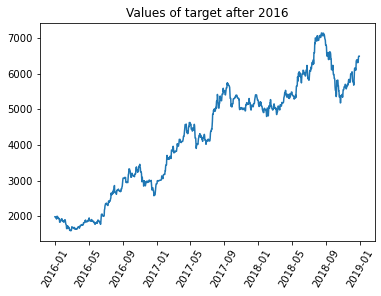

In [51]:
plt.plot(x_train, y_train);
plt.title(f"Values of target after {y_train.index.min().year}")
plt.xticks(rotation=60);

### Daily data decomposition

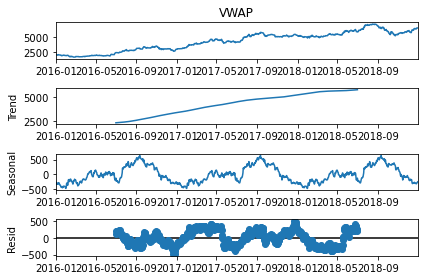

In [52]:
result = seasonal_decompose(y_train, model='additive', period=365)
result.plot()
plt.show();

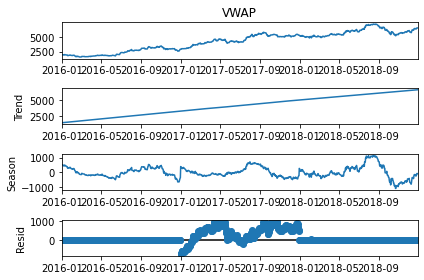

In [53]:
result = STL(y_train, period=365, robust=True).fit()
result.plot()
plt.show();

### Monthly data decomposition

High frequency data may consist of several seasonal components. Simple models cannot work with multiseasonaluty, so sometimes makes sense to reconstruct series based on components computed for different frequencies.

In [54]:
y_montly_ser = y_train.resample("m").mean()

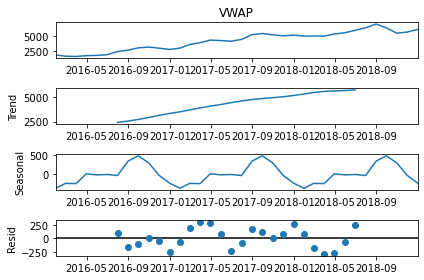

In [55]:
result = seasonal_decompose(y_montly_ser, model='additive', period=12)
result.plot()
plt.show();

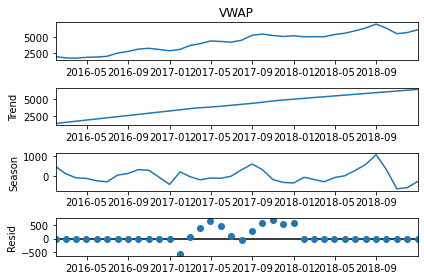

In [56]:
result = STL(y_montly_ser, period=12, robust=True).fit()
result.plot()
plt.show();

## Fast Fourier transform

Some code from is taken from the article https://towardsdatascience.com/analyzing-seasonality-with-fourier-transforms-using-python-scipy-bb46945a23d3

### Get seasonality from frequencies (raw data)

In [57]:
y_fft = fft.fft(y_train)

power = np.abs(y_fft)
freq = fft.fftfreq(n_train)

mask = freq >= 0
freq = freq[mask]
power = power[mask]

mask = (freq > 0) & (freq <= 0.02) # set manually after studing the plot
freq_filtered = freq[mask]
power_filtered = power[mask]

peaks = sig.find_peaks(power_filtered)[0]
peak_freq =  freq_filtered[peaks]
peak_power = power_filtered[peaks]

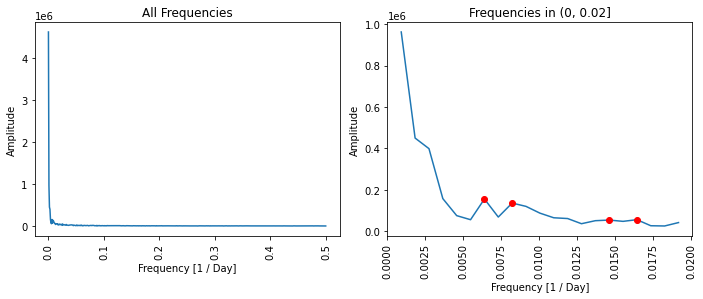

In [58]:
plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='signal')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Day]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(freq_filtered, power_filtered)
ax2.set_title('Frequencies in (0, 0.02]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Day]' )


plt.plot(peak_freq, peak_power, 'ro')
plt.tight_layout()
plt.xticks(rotation=90);

The same plots, but the second is zoomed.

Spikes show the frequencies at which we see the strongest presence of frequency in data. The first values are high because it catches the trend in data and probably approximates it with sin function, but it can be tricky to use it because in future prediction may go down according to sin periodicity.

How do you think, what is the interpretation of the first component of y_fft (value with the highest amplitude)? 

Let's look at the found seasonalities, Fourier analysis tells us that we have 156 day cycle.

In [59]:
fft_output = pd.DataFrame()
fft_output['peak_i'] = peaks
fft_output['freq'] = peak_freq
fft_output['amplitude'] = peak_power
fft_output['period (days)'] = 1 / peak_freq
fft_output['fft'] = y_fft[peaks]
fft_output = fft_output.sort_values('amplitude', ascending=False)

fft_output

,peak_i,freq,amplitude,period (days),fft
0,6,0.006393,155180.907956,156.428571,-42017.282702+35700.410517j
1,8,0.008219,135562.137792,121.666667,29247.571626+61405.562398j
3,17,0.016438,55263.162723,60.833333,4351.842431+46966.836327j
2,15,0.014612,53435.582606,68.437500,2099.256204+50304.053567j


### Prepare data

1. We need to remove trend (why? can you explain?)
2. For real-life (economical, finincial) time series we almost never see the linear trend, usual we acceleration is negative

In [60]:
y_df = y_train.to_frame()
y_df.columns = ["y"]

y_df_test = y_test.to_frame()
y_df_test.columns = ["y"]

In [61]:
x_float = x_train.values.astype(float)
x_float_min = np.min(x_float)
x_float_norm = np.log(x_float / x_float_min)

x_test_float = x_test.values.astype(float)
x_test_float_norm = np.log(x_test_float / x_float_min)

In [62]:
trend_coef = np.polyfit(x_float_norm , y_df["y"].values, 1)
trend = trend_coef[0] * x_float_norm + trend_coef[1]
trend_test = trend_coef[0] * x_test_float_norm + trend_coef[1]

In [63]:
y_df["trend"] = trend
y_df["y_detrended"] = y_df["y"] - y_df["trend"]

y_df_test["trend"] = trend_test
y_df_test["y_detrended"] = y_df_test["y"] - y_df_test["trend"]

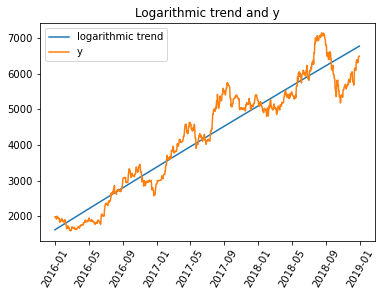

In [64]:
plt.plot(x_train, trend, label="logarithmic trend")
plt.plot(x_train, y_df["y"], label="y")
plt.title("Logarithmic trend and y");
plt.legend();
plt.xticks(rotation=60);
plt.show();


### Denoising / Forecasting

In [65]:
yhat_fft = dict()
fig = go.Figure()
colors = px.colors.sequential.Plasma_r
colors = px.colors.qualitative.Pastel

for i, k in enumerate([5, 10, 15, 20, 30]):
    yhat_fft[k] = fourier_extrapolation(y_df["y_detrended"].values, n_test, k)
    fig.add_trace(go.Scatter(
        x=x_train, y=yhat_fft[k][:n_train], mode='lines', 
        name=f"y detrended from Fourier({k})", 
        line={"color": colors[i], "width": 2}
    ))

fig.add_trace(go.Scatter(
    x=x_train, y=y_df["y_detrended"], mode='lines', 
    name=f"y detrended", line={"color": "grey", "width": 1}))
fig.update_layout(
        title = "Reconstruction of series from Fourier transform",
        xaxis_tickformat = '%d %B <br>%Y',
        template="plotly_white"
    )

In [66]:
k = 10
yhat = yhat_fft[k][:n_train]
yhat_test = yhat_fft[k][-n_test : ]

In [67]:
y_df["fft_comp"] = yhat
y_df_test["fft_comp"] = yhat_test

Add trend back

In [68]:
y_df["y_hat"] = (y_df["trend"] + y_df["fft_comp"])
y_df_test["y_hat"] = (y_df_test["trend"] + y_df_test["fft_comp"])

In [69]:
yhat = y_df["y_hat"].values
yhat_test = y_df_test["y_hat"].values

In [70]:
make_plots(
    f"Prediction based on log transform + FFT({k})", 
    x_train, y_train, x_test, y_test, yhat, yhat_test
)

HW: check how the forecast changes if we consider only 1 year for transformation

In [71]:
print_report(y_test, yhat_test, mask_true_test)

+-----------------------------------------+--------------------+
|                  Metric                 |       Value        |
+-----------------------------------------+--------------------+
|         SMAPE % (less is better)        | 6.0856452582486495 |
|   Scaled MAE on naive (less is better)  | 46.00580879271775  |
|   MAE weekly weighted (less is better)  | 497.22294343847517 |
| Correlation similarity (more is better) | 0.5762832800045702 |
+-----------------------------------------+--------------------+


## Prophet

In [1]:
!pip install pystan==2.19.1.1

In [ ]:
# y_ser_full = pd.concat([y_ser, y_ser_test])
y_prophet = y_train.to_frame().reset_index()
y_prophet.columns = ["ds", "y"]

m = Prophet()
m.fit(y_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KeyError: 'metric_file'

In [ ]:
future = m.make_future_dataframe(periods=366)
fcst = m.predict(future)
fig = m.plot(fcst)

In [ ]:
fcst.set_index("ds", inplace=True)
fcst

In [ ]:
make_plots(
    f"Prediction based on log transform + FFT({k})", 
    x_train, y_train, x_test, y_test, fcst.loc[x_train, "yhat"], fcst.loc[x_test, "yhat"]
)

In [ ]:
print_report(y_test, yhat_test, mask_true_test)

###  Study horizon of ferecasting

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values. This figure illustrates a simulated historical forecast on the Peyton Manning dataset, where the model was fit to a initial history of 5 years, and a forecast was made on a one year horizon.

https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning

![image.png](attachment:image.png)

In [ ]:
y_prophet = pd.concat([y_train, y_test]).to_frame().reset_index()
y_prophet.columns = ["ds", "y"]

m = Prophet()
m.fit(y_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KeyError: 'metric_file'

Exception ignored in: 'stanfit4anon_model_f5236004a3fd5b8429270d00efcc0cf9_9045703871880297330._set_stanargs_from_dict'
Traceback (most recent call last):
  File "C:\Users\agama\anaconda3\envs\course\lib\site-packages\pystan\model.py", line 550, in optimizing
    ret, sample = fit._call_sampler(stan_args)
KeyError: 'metric_file'


In [ ]:
df_cv = cross_validation(m, initial='1065 days', period='30 days', horizon = '365 days')

In [ ]:
df_cv.head()

In [ ]:
df_cv.tail()

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head()

In [ ]:
df_p.tail()

Dots show MAE for each prediction in df_cv. The blue line shows the MAE, where the mean is taken over a rolling window of the dots.

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mae')